In [26]:

import time
import utils.helper_methods as helper_methods
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# import generateGraph
import numpy as np
import random
import pickle5 as pickle


# graphFile = "./contribConnected.gexf"
# gph = nx.read_gexf(graphFile)


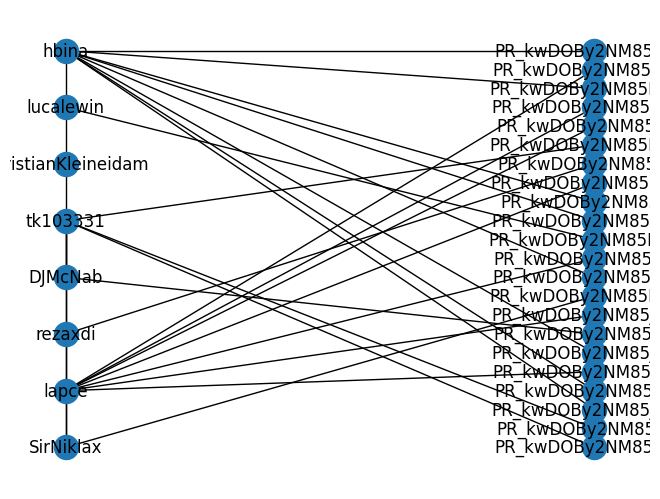

In [27]:

graphFile = "../graphs/v3Mini10000/contribConnected.gexf"
edgeCountForDisplay = 30




try:
    gph = nx.read_gexf(graphFile)
    # helper_methods.logData("graph file found at " + str())
except Exception as e:
    # helper_methods.logData(e)
    gph = nx.Graph()
    # helper_methods.logData("new graph file generated")



sampleNodeList = []
sampleEdgeList = []
userList = []
for n in gph.nodes(data = True):
    sampleNodeList.append(str(n[0]))
    
    if(n[1]['bipartite'] == 0):
        userList.append(str(n[0]))
    
    edgeCountForDisplay -= 1
    if(edgeCountForDisplay == 0):
        break


# subgraph_nodes = [1, 2, 'a', 'b', 'c', 'd', 'e', 'f']
subgraph = gph.subgraph(sampleNodeList)        
pos = nx.bipartite_layout(subgraph, userList)
nx.draw(subgraph, pos, with_labels=True)
plt.show()

In [28]:
B = gph

users = [n for n, d in B.nodes(data=True) if d["bipartite"] == 0]
issues = [n for n, d in B.nodes(data=True) if d["bipartite"] == 1]



In [5]:


def jaccard_coefficient(graph, node1, node2):
    neighbors1 = set(graph.neighbors(node1))
    neighbors2 = set(graph.neighbors(node2))
    intersection = neighbors1.intersection(neighbors2)
    union = neighbors1.union(neighbors2)
    if len(union) == 0:
        return 0
    return len(intersection) / len(union)


def jaccard_link_prediction(graph, threshold):
    predicted_edges = []
    count = 10000
    userCount = 0
    for node1 in users:
        
        userCount += 1
        if(userCount%100 == 0):
            print(userCount)
        for node2 in issues:
            
            if node1 == node2 or graph.has_edge(node1, node2):
                continue
            
            jaccard = jaccard_coefficient(graph, node1, node2)
            if(jaccard >=threshold):
                
                predicted_edges.append((node1, node2, jaccard))
                count -= 1
                if(count == 0):
                    print(node1,end="-------")
                    print(node2, end="-------")
                    print(jaccard)
                    count = 10000
                    
    return sorted(predicted_edges, key=lambda x: x[2], reverse=True)




In [25]:
def adamic_adar(u, v, G):
    neighbors = list(nx.common_neighbors(G, u, v))
    score = 0
    for w in neighbors:
        degree = G.degree(w)
        if degree != 0:
            score += 1 / np.log(degree)
    return score



def adamicAdar(g):
    similarity_scores = {}
    for u in users:
        for v in issues:
            if not g.has_edge(u, v):
                score = adamic_adar(u, v, B)
                similarity_scores[(u, v)] = score

    # Sort the similarity scores in descending order
    sorted_scores = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_scores

In [6]:


def preferential_attachment(G, issue, user):
    issue_neighbors = set(G.neighbors(issue))
    user_neighbors = set(G.neighbors(user))
    return len(issue_neighbors) * len(user_neighbors)


def prefAttach(gph, threshold):
    predicted = []
    for issue in issues:
        for user in users:
            if gph.has_edge(user, issue):
                continue
            score = preferential_attachment(gph, issue, user)
            if (score>=threshold):
                predicted.append((issue, user, score))
    return sorted(predicted, key=lambda x: x[2], reverse=True)
           

In [30]:
def ptgb(gph):
    values = {}
    contributions = set() # all nodes with type contribution
    starred = set() # all nodes with type starred repo

    for n in gph.nodes(data = True):
        if n[1]['bipartite'] == 0:
            values[n[0]] = 1
        else:
            values[n[0]] = 2

    for n in gph.edges(data = True):
        if 'contributions' in n[2]:
            contributions.add(n[0])
            contributions.add(n[1])
        else:
            starred.add(n[0])
            starred.add(n[1])

    # users -> 1
    # issues -> 2
    # contribution -> 3
    # starred -> 4

    threshold = 3
    predicted = []

    for node in gph.nodes():

        if values[node] == 1: # if it is user
            current_user = node
            weight = {} # to store weights of issues
            prediction = []
            for nodes in gph.neighbors(current_user):
                if values[nodes] == 2: # issues connected to users
                    issues = nodes
                    for issue_neigh in gph.neighbors(issues): # neighbours of issues connected to users
                        if values[issue_neigh] == 2:
                            if issue_neigh in weight:
                                weight[issue_neigh] += 1
                            else:
                                weight[issue_neigh] = 1
                else: # users connected to users
                    user = nodes
                    if user in contributions: # if user is connected via contribution
                        for issue_neigh in gph.neighbors(user): # issues that are neighbours of users connected to cuurent user 
                            if values[issue_neigh] == 2:
                                if issue_neigh in weight:
                                    weight[issue_neigh] += 2
                                else:
                                    weight[issue_neigh] = 2
                    else: # if user is connected via starred repo
                        for issue_neigh in gph.neighbors(user): # issues that are neighbours of users connected to cuurent user
                            if values[issue_neigh] == 2:
                                if issue_neigh in weight:
                                    weight[issue_neigh] += 1
                                else:
                                    weight[issue_neigh] = 1
            
            Issues = list(weight.keys())
            Weights = list(weight.values())

            # print(current_user, end = " --> ")
            # Probability = Element Weight / Sum Of All Weights
            # predicted_issue = random.choices(Issues, Weights, k = 1)[0]
            # print(predicted_issue) # k is the number of outputs
            sorted_prediction = sorted(weight.items(), key=lambda x: x[1], reverse=True)
            # print(sorted_prediction)
            for x in range(0,len(sorted_prediction)):
                if(sorted_prediction[x][1] > 1):
                    predicted_issue = sorted_prediction[x][0]
                    predicted.append([current_user, predicted_issue])
    return predicted


In [33]:
def weighted_projected_graph(B, nodesU,nodesI, weight_function=None):
    # Create a new graph for the weighted projection
    W = nx.Graph()

    # Get the nodes from one bipartite node set
    # if nodes is None:
    #     nodes = set(B)

    # Get the weights for the nodes
    if weight_function is None:
        weight_function = lambda x, y, r: len(r)

    # For each pair of nodes in the same bipartite node set
    for u in nodesU:
        for v in nodesI:
            # if u == v:
            #     continue
            neighbors_u = set(B[u])
            neighbors_v = set(B[v])

            # Find the shared neighbors of u and v
            shared_neighbors = neighbors_u & neighbors_v

            # Calculate the similarity probability
            weight = weight_function(u, v, shared_neighbors)

            # Add the weighted edge to the new graph
            if weight > 0:
                W.add_edge(u, v, weight=weight)
    max_weight = max(nx.get_edge_attributes(W, 'weight').values())

    print(max_weight)

    for u, v, weight in W.edges(data='weight'):
        W[u][v]['weight'] = weight / max_weight

    sorted_edges = sorted(W.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

    return sorted_edges


def weight_function(u, v, shared_neighbors):
    return len(shared_neighbors)

# Call the weighted_projected_graph function with the bipartite graph and the weight function
# W = weighted_projected_graph(C_sub, nodes=C_sub.nodes, weight_function=weight_function)
# W = weighted_projected_graph(B, users,issues, weight_function=weight_function)

# Print the weighted projected graph
# print(W.edges(data=True))



In [9]:
# Set the number of nodes and edges to extract
C= B

usersC = [n for n, d in C.nodes(data=True) if d["bipartite"] == 0]
issuesC = [n for n, d in C.nodes(data=True) if d["bipartite"] == 1]

C=B
# Initialize sets for each partition
setA = set()
setB = set()
setAll= set()
count = 50

# Iterate through the graph and populate sets for each partition
for n in C.nodes(data = True):
    setAll.add(str(n[0]))
    
    if(n[1]['bipartite'] == 0):
        setA.add(str(n[0]))
    else:
        setB.add(str(n[0]))
    # count -= 1
    # if(count == 0):
    #     break


C_edges = []
for u in C:
        for v in C[u]:
            if u==v or (u not in usersC):
                  continue
            #print(f"Edge: {u} - {v}")
            C_edges.append((u,v))

# print(C_edges)
i=0;
for u in C_edges:
        if i<10:
               print(f"Edge: {u}")
               i=i+1


def resource_allocation(G, u, v):
    neighbors_u = set(G[u])
    neighbors_v = set(G[v])
    common_neighbors = neighbors_u.intersection(neighbors_v)
    score = 0
    for neighbor in common_neighbors:
        degree = len(list(G.neighbors(neighbor)))
        score += 1 / degree
    return score

# Compute resource allocation scores for all pairs of nodes in set A and set B
def resAlloc(gph):
    predicted_edges = []
    for u in setA:
        for v in setB:
            if not gph.has_edge(u, v):
                score = resource_allocation(gph, u, v)
                predicted_edges.append((u, v, score))

    # Sort the predicted edges by resource allocation score in descending order
    predicted_edges.sort(key=lambda x: x[2], reverse=True)

    return predicted_edges

# Print the top 3 predicted edges with the highest resource allocation scores
# print("Top 10 Predicted Edges:")
# for i in range(2):
#     print(f"Edge: {predicted_edges[i][0]} - {predicted_edges[i][1]}, Resource Allocation Score: {predicted_edges[i][2]}")

Edge: ('lapce', 'PR_kwDOBy2NM85LQJYb')
Edge: ('lapce', 'PR_kwDOBy2NM85LAawJ')
Edge: ('lapce', 'PR_kwDOBy2NM85Jeo7e')
Edge: ('lapce', 'PR_kwDOBy2NM85JX6tb')
Edge: ('lapce', 'PR_kwDOBy2NM85JKB2s')
Edge: ('lapce', 'PR_kwDOBy2NM85JIfZE')
Edge: ('lapce', 'PR_kwDOBy2NM85IvbF4')
Edge: ('lucalewin', 'PR_kwDOBy2NM85K9kR7')
Edge: ('SirNiklax', 'PR_kwDOBy2NM85K9bUt')
Edge: ('SirNiklax', 'DJMcNab')


In [10]:
def removeEdges(graph, n):
    g = nx.Graph()
    initial = graph.number_of_edges()
    issuesList = random.sample(issues, n)
    for i in issuesList:
        for j in list(graph.neighbors(i)):
            if graph.nodes[j]["bipartite"] == 0:
                g.add_node(i, bipartite=1)
                g.add_node(j, bipartite=0)
                g.add_edge(i,j)
                graph.remove_edge(i,j)
    final = graph.number_of_edges()
    print(initial - final)
    return g,graph

X = gph.copy()
train, test = removeEdges(X,2000)

2000


In [11]:
og_list = train.edges()
og_list = list(og_list)

In [12]:
def commonEdges(pred):
    common_edges = []

    for edge1 in pred:
        for edge2 in og_list:
    
            sorted_edge1 = tuple(sorted(edge1))
            sorted_edge2 = tuple(sorted(edge2))
            if sorted_edge1 == sorted_edge2:
                common_edges.append(edge1)
                break
    return common_edges

In [33]:
pred_jaccard = jaccard_link_prediction(test, 0.01)
for i in range(len(pred_jaccard)):
    pred_jaccard[i] = pred_jaccard[i][:2]
common_jaccard = commonEdges(pred_jaccard)

with open('jaccard.pickle', 'wb') as f:
    pickle.dump(common_jaccard, f)

100
TomLiu-GitHub-------MDExOlB1bGxSZXF1ZXN0MzY1MzUxOTk4-------0.012048192771084338
200
300
400
Tamir198-------PR_kwDOD0USHc5LJeTa-------0.012195121951219513
500
600
700
proninyaroslav-------PR_kwDOAOCAEs5JlVzA-------0.013513513513513514
800
900
ErrorsWindows-------MDExOlB1bGxSZXF1ZXN0MTcyOTY3OTE=-------0.023809523809523808
1000
1100
Atermonera-------PR_kwDOB-PfJM5KYiC--------0.010526315789473684
1200
1300
OracleStation-------MDExOlB1bGxSZXF1ZXN0MTgzMzYzMzE3-------0.05
1400
RegJoe-------PR_kwDODJ5mGM5JSmXX-------0.1
1500
1600
1700
deby22-------PR_kwDOAKJ_Hs5JqQV4-------0.011904761904761904
1800
1900
2000
2100
dominant-strategies-------PR_kwDOBrnV384vJSSm-------0.012987012987012988
2200
2300
2400
2500
2600
chukinas-------PR_kwDOANwOQc5Jcnnh-------0.012658227848101266
2700
2800
2900
whiteChen233-------PR_kwDOAocbZM5I65-N-------0.012987012987012988
3000
3100


In [34]:
pred_adamic = adamicAdar(test)

for i in range(len(pred_adamic)):
    pred_adamic[i] = pred_adamic[i][0]

common_adamic = commonEdges(pred_adamic)

with open('adamic.pickle', 'wb') as f:
    pickle.dump(common_adamic, f)

In [19]:

pred_prefAttach = prefAttach(test,50000)

In [ ]:
x = pred_prefAttach

for i in range(len(x)):
    x[i] = x[i][:2]


In [21]:

for i in pred_prefAttach:
    print(i)

common_prefAttach = commonEdges(pred_prefAttach)

with open('prefAttach.pickle', 'wb') as f:
    pickle.dump(common_prefAttach, f)

('PR_kwDOAiEj5s5JN1-j', 'devonestes')
('PR_kwDOAiEj5s5JJcOU', 'devonestes')
('PR_kwDOAiEj5s5JN1-j', 'stevedomin')
('PR_kwDOAiEj5s5JJcOU', 'stevedomin')
('PR_kwDOAiEj5s5JN1-j', 'milmazz')
('PR_kwDOAiEj5s5JJcOU', 'milmazz')
('PR_kwDOAiEj5s5JN1-j', 'britto')
('PR_kwDOAiEj5s5JJcOU', 'britto')
('PR_kwDOAiEj5s5JN1-j', 'jonatanklosko')
('PR_kwDOAiEj5s5JJcOU', 'jonatanklosko')
('PR_kwDOAiEj5s5JN1-j', 'balexand')
('PR_kwDOAiEj5s5JJcOU', 'balexand')
('PR_kwDOAiEj5s5JN1-j', 'rhnonose')
('PR_kwDOAiEj5s5JJcOU', 'rhnonose')
('PR_kwDOAiEj5s5JN1-j', 'herminiotorres')
('PR_kwDOAiEj5s5JJcOU', 'herminiotorres')
('PR_kwDOAiEj5s5JN1-j', 'christopheradams')
('PR_kwDOAiEj5s5JJcOU', 'christopheradams')
('PR_kwDOAiEj5s5JN1-j', 'feliperenan')
('PR_kwDOAiEj5s5JJcOU', 'feliperenan')
('PR_kwDOAiEj5s5JN1-j', 'btkostner')
('PR_kwDOAiEj5s5JJcOU', 'btkostner')
('PR_kwDOAiEj5s5K4pqq', 'devonestes')
('PR_kwDOAiEj5s5JN1-j', 'Benjamin-Philip')
('PR_kwDOAiEj5s5JJcOU', 'Benjamin-Philip')
('PR_kwDOAiEj5s5K4pqq', 'stevedomin'

In [31]:
pred_ptgb = ptgb(test)
common_ptgb = commonEdges(pred_ptgb)

with open('ptgb.pickle', 'wb') as f:
    pickle.dump(common_ptgb, f)

In [24]:
pred_resAlloc = resAlloc(test)


for i in range(len(pred_resAlloc)):
    pred_resAlloc[i] = pred_resAlloc[i][:2]

# common_resAlloc = commonEdges(pred_resAlloc)

# with open('resAlloc.pickle', 'wb') as f:
#     pickle.dump(common_resAlloc, f)


KeyboardInterrupt: 

In [36]:
pred_weighted = weighted_projected_graph(test, users,issues, weight_function=weight_function)

# common_weighted = commonEdges(pred_weighted)

# with open('weighted.pickle', 'wb') as f:
#     pickle.dump(common_weighted, f)

25


In [86]:
x = []
for i in pred_weighted:
    # print(i)
    if (i[2]['weight']>0.05):
        x.append(tuple((str(i[0]),str(i[1]))))

        
    # i.append(i[2].values())

In [87]:
print(len(x))
# print(og_list)
common_weighted = commonEdges(x)

with open('weighted.pickle', 'wb') as f:
    pickle.dump(common_weighted, f)

5312


In [89]:
print(len(common_weighted))
for i in common_weighted:
    print(i)

6
('kaina404', 'MDExOlB1bGxSZXF1ZXN0MjYzMTA4MTQ0')
('kaina404', 'MDExOlB1bGxSZXF1ZXN0MjYxOTk4Nzg5')
('lapce', 'PR_kwDOBy2NM85JX6tb')
('login', 'MDExOlB1bGxSZXF1ZXN0MTgxNjM3NDA4')
('login', 'MDExOlB1bGxSZXF1ZXN0OTc0NjUxMjc=')
('login', 'MDExOlB1bGxSZXF1ZXN0MTQ3OTQ5MTAx')
